In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Gets the box score of every single game (NBA + WNBA + others: nba.com doesn't seperate the leagues) 
# from 2014-2021 into a dataframe.
all_games_finder = leaguegamefinder.LeagueGameFinder()
all_games = all_games_finder.get_data_frames()[0]

# Creates empty dataframe with the same column names passed in from the dataframe containing all the games.
column_names = all_games.columns
games = pd.DataFrame(columns = column_names)

# Appends every game containing an NBA team in the all_games df to the games df. 
nba_teams = teams.get_teams()
for team in nba_teams:
    temp_id = team['id']
    games = games.append(all_games[all_games['TEAM_ID'] == temp_id])

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 28 to 29974
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          18000 non-null  object 
 1   TEAM_ID            18000 non-null  object 
 2   TEAM_ABBREVIATION  18000 non-null  object 
 3   TEAM_NAME          18000 non-null  object 
 4   GAME_ID            18000 non-null  object 
 5   GAME_DATE          18000 non-null  object 
 6   MATCHUP            18000 non-null  object 
 7   WL                 17992 non-null  object 
 8   MIN                18000 non-null  object 
 9   PTS                18000 non-null  object 
 10  FGM                18000 non-null  object 
 11  FGA                18000 non-null  object 
 12  FG_PCT             17998 non-null  float64
 13  FG3M               18000 non-null  object 
 14  FG3A               18000 non-null  object 
 15  FG3_PCT            17997 non-null  float64
 16  FTM                18

In [2]:
# Dropping any game (two rows in DF) that has any NaN values.

games.isna()
games.dropna(inplace = True)

games = games[games.duplicated(subset = ['GAME_ID'], keep = False)]
 
# Merging games together (previously seperated in the DF by team: each team's stats from the game were kept in seperate rows
games = games.sort_values(by=['GAME_ID'])

games = games.reset_index(drop = True)

gamesteam1 = games[games.index % 2 == 0]
gamesteam2 = games[games.index % 2 == 1]

gamesteam1 = gamesteam1.reset_index(drop=True)
gamesteam2 = gamesteam2.reset_index(drop=True)

games = gamesteam1.join(gamesteam2, rsuffix='_other')

games.head(25)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT_other,OREB_other,DREB_other,REB_other,AST_other,STL_other,BLK_other,TOV_other,PF_other,PLUS_MINUS_other
0,12015,1610612746,LAC,LA Clippers,0011500001,2015-10-02,LAC vs. DEN,W,238,103,...,0.750,14,43,57,16,9,2,23,26,-7.0
1,12015,1610612753,ORL,Orlando Magic,0011500002,2015-10-03,ORL vs. CHA,L,240,100,...,0.743,7,34,41,30,7,2,13,15,6.0
2,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,IND vs. NOP,L,241,105,...,0.676,19,36,55,16,9,3,11,22,5.0
3,12015,1610612762,UTA,Utah Jazz,0011500004,2015-10-04,UTA @ LAL,W,240,90,...,0.619,14,34,48,11,8,6,13,31,-19.0
4,12015,1610612746,LAC,LA Clippers,0011500005,2015-10-04,LAC @ TOR,L,240,73,...,0.806,9,39,48,11,12,6,19,25,20.0
5,12015,1610612766,CHA,Charlotte Hornets,0011500006,2015-10-04,CHA @ MIA,W,240,90,...,0.700,9,39,48,19,9,4,14,24,-13.0
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,POR vs. SAC,L,266,105,...,0.643,14,36,50,25,10,5,23,18,4.0
7,12015,1610612744,GSW,Golden State Warriors,0011500009,2015-10-05,GSW vs. TOR,W,240,95,...,0.826,15,33,48,15,10,0,14,19,-8.0
8,12015,1610612762,UTA,Utah Jazz,0011500010,2015-10-07,UTA @ LAL,W,264,117,...,0.761,14,27,41,16,9,4,19,31,-3.0
9,12015,1610612764,WAS,Washington Wizards,0011500011,2015-10-06,WAS vs. PHI,W,240,129,...,0.667,6,36,42,22,6,8,23,20,-34.0


In [3]:
#Things to drop later:
#team ID, not relevant and good teams might be identified by this => more bias
#Ironically, block percentage only really correlates to total blocks (maybe not, bc there's a few blocks that also correlate either negatively or positively to blkp)
#Maybe freethrough percent? It correlates to a few other things so I'm not sure If we should really. 
games = games.drop(columns=['SEASON_ID_other', 'GAME_DATE_other']) #irrelevant and basically an exact duplicate of that in the first column.
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8947 entries, 0 to 8946
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEASON_ID                8947 non-null   object 
 1   TEAM_ID                  8947 non-null   object 
 2   TEAM_ABBREVIATION        8947 non-null   object 
 3   TEAM_NAME                8947 non-null   object 
 4   GAME_ID                  8947 non-null   object 
 5   GAME_DATE                8947 non-null   object 
 6   MATCHUP                  8947 non-null   object 
 7   WL                       8947 non-null   object 
 8   MIN                      8947 non-null   object 
 9   PTS                      8947 non-null   object 
 10  FGM                      8947 non-null   object 
 11  FGA                      8947 non-null   object 
 12  FG_PCT                   8947 non-null   float64
 13  FG3M                     8947 non-null   object 
 14  FG3A                    

In [4]:
games["BLK%"] = 100 * (games["BLK"] * (games["MIN"]/5))/ (games["MIN"] * (games["FGA_other"] - games["FG3A_other"])) 

#Turnover Percentage (TOV)             | TOV / (FGA + 0.44 * FTA + TOV)     TOV = turnovers
games["TOV%"] = games["TOV"] / (games["FGA"] + 0.44*games["FTA"] + games["TOV"])

#Offensive Rebound Percentage (ORB)    | ORB / (ORB + Opp DRB)              Opp = oppenent
games["ORB%"] = games["OREB"] / (games["OREB"] + games["DREB_other"])

#Defensive Rebound Percentage (DRB)    | DRB / (Opp ORB + DRB)              Opp = oppenent
games["DREB%"] = games["DREB"] / (games["OREB_other"] + games["DREB"])

#(POSS)
# need to get the bloody parenthesis correctly done!
#games["POSS"] = 0.5*((games["FGA"] + 0.4*games["FTA"] - 1.07*(games["OREB"]/(games["OREB"] + games["OREB_other"])) * (games["FGA"] - games["FGM"]) + games["TOV"]) + games["FGA_other"] + 0.4*games["FTA_other"] - 1.07 * (games["OREB_other"] / (games["OREB_other"] + games["DREB"])) * (games["FGA_other"] - games["FGM_other]) + games["TOV_other"]))

# simpler POSS
games["POSS"] = 0.96*((games["FGA"]) + games["TOV"] + 0.44*games["FTA"] - games["OREB"])

# used for PACE; probably wrong
games["POSS_other"] = 0.96*((games["FGA_other"]) + games["TOV_other"] + 0.44*games["FTA_other"] - games["OREB_other"])

#STLP
games["STL%"] = 100 * (games["STL"] * (games["MIN"]/5))/ (games["MIN"] * games["POSS"]) #need POSS feature

#FTR
games["FTR"] = games["FTM"] / games["FGA"]

#TS (you'll need to calculate TSA as well)
games["TSA"] = games["FGA"] + 0.44*games["FTA"]
games["TS"] = games["PTS"]/(2*games["TSA"])

#ASTR
games["ASTR"] = 100*games["AST"]/ (((games["MIN"]/(games["MIN"]/5)) * games["FGM"]) - games["FGM"])

#TRB
games["TRB%"] = 100*(games["REB"] * (games["REB"]/5))/(games["MIN"] * (games["REB"] + games["REB_other"]))

#PACE
games["PACE"] = 48*((games["POSS"] + games["POSS_other"])/(2*(games["MIN"]/5)))

#ORTG
games["ORTG"] = 100*(games["PTS"]/games["POSS"])

#DRTG
games["DRTG"] = 100*(games["PTS_other"]/games["POSS"])

#PER

print(games.columns)
games.head(10)

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'TEAM_ID_other',
       'TEAM_ABBREVIATION_other', 'TEAM_NAME_other', 'GAME_ID_other',
       'MATCHUP_other', 'WL_other', 'MIN_other', 'PTS_other', 'FGM_other',
       'FGA_other', 'FG_PCT_other', 'FG3M_other', 'FG3A_other',
       'FG3_PCT_other', 'FTM_other', 'FTA_other', 'FT_PCT_other', 'OREB_other',
       'DREB_other', 'REB_other', 'AST_other', 'STL_other', 'BLK_other',
       'TOV_other', 'PF_other', 'PLUS_MINUS_other', 'BLK%', 'TOV%', 'ORB%',
       'DREB%', 'POSS', 'POSS_other', 'STL%', 'FTR', 'TSA', 'TS', 'ASTR',
       'TRB%', 'PACE', 'ORTG', 'DRTG'],
      dtype='object')


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,POSS_other,STL%,FTR,TSA,TS,ASTR,TRB%,PACE,ORTG,DRTG
0,12015,1610612746,LAC,LA Clippers,0011500001,2015-10-02,LAC vs. DEN,W,238,103,...,100.608,2.348741,0.21978,102.44,0.502733,14.864865,1.331408,102.247261,100.800138,93.949643
1,12015,1610612753,ORL,Orlando Magic,0011500002,2015-10-03,ORL vs. CHA,L,240,100,...,92.544,2.353807,0.179775,97.36,0.513558,14.102564,1.962209,93.0048,106.991235,113.410709
2,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,IND vs. NOP,L,241,105,...,106.8288,1.953613,0.206522,105.64,0.496971,13.815789,2.726531,104.167568,102.564704,107.448737
3,12015,1610612762,UTA,Utah Jazz,0011500004,2015-10-04,UTA @ LAL,W,240,90,...,94.3104,1.950687,0.465753,94.12,0.478113,18.518519,2.777778,93.2928,97.534332,76.943751
4,12015,1610612746,LAC,LA Clippers,0011500005,2015-10-04,LAC @ TOR,L,240,73,...,94.8864,1.265182,0.197183,79.8,0.457393,14.814815,1.12037,94.8672,76.96525,98.051619
5,12015,1610612766,CHA,Charlotte Hornets,0011500006,2015-10-04,CHA @ MIA,W,240,90,...,91.008,1.509037,0.351351,87.64,0.513464,12.5,2.253333,91.8912,97.00952,82.997034
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,POR vs. SAC,L,266,105,...,107.8272,2.082576,0.111111,106.04,0.495096,14.285714,1.993218,96.300271,99.395674,103.182176
7,12015,1610612744,GSW,Golden State Warriors,0011500009,2015-10-05,GSW vs. TOR,W,240,95,...,90.3552,1.781388,0.257143,80.56,0.589623,20.714286,1.342157,90.0864,105.769916,96.862976
8,12015,1610612762,UTA,Utah Jazz,0011500010,2015-10-07,UTA @ LAL,W,264,117,...,103.9104,2.537794,0.320988,97.72,0.598649,16.463415,1.783827,93.800727,114.200712,111.272489
9,12015,1610612764,WAS,Washington Wizards,0011500011,2015-10-06,WAS vs. PHI,W,240,129,...,102.6432,1.882303,0.1875,105.68,0.610333,18.75,2.068352,104.448,121.408565,89.409409


In [5]:
# code below updates the games.csv with the new features added
# and saves it to games_updated.cs

games_csv = games
games_csv.to_csv("games_updated.csv")

<AxesSubplot:>

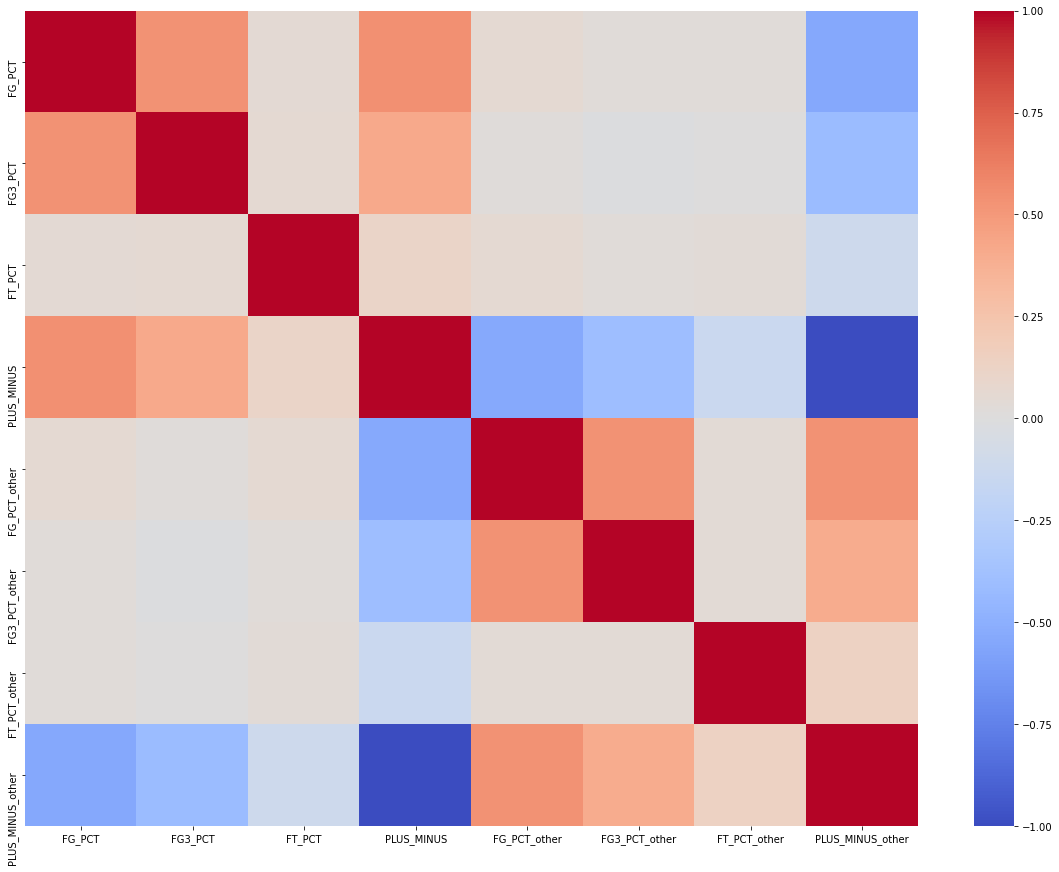

In [6]:
#Data Visualizaiton
plt.figure(figsize=(20,15))
sns.heatmap(games.corr(),cmap='coolwarm', vmin = -1)

In [ ]:
# ~ TO-DO: 
#  > simple statistics for each feature; mean, median, nth quartile, ...
#  > simple histogram; just to show basic statistics
#  > cleanup, normalize data (???)
#  > udpate document report